### **Installing the required packages**

In [1]:
# installing required libraries
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### **Importing the required libraries**

In [4]:
# importing the necessary libraries
import os
import re
import nltk
import pandas as pd
import seaborn as sns
from google.colab import files
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

import spacy
from nltk.stem.snowball import SnowballStemmer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## **Loading the datasets**<br/>
Loading the extracted dataset (**twitter_climate_keyword_extracted_data.csv**) prepared in **Mini Project 3_Dataset_collection colab** notebook. Also loading the labeled dataset obtained from Kaggle (**twitter_sentiment_data.csv**).<br/>
Source of the Kaggle dataset: https://www.kaggle.com/datasets/edqian/twitter-climate-change-sentiment-dataset?resource=download 

### **Labeled dataset description**<br/>
The dataset contains 43943 tweets related to climate change collected between April 27, 2015, and February 21, 2018. The labels in the data are described as:

*   2 (News)   : the tweet links to factual news about climate change
*   1 (Pro)    : the tweet supports the belief of man-made climate change
*   0 (Neutral): the tweet neither supports nor refutes the belief of man-made climate change
*   -1 (Anti)  : the tweet does not believe in man-made climate change

### **Extracted tweets dataset description**<br/>
The dataset was prepared by collecting the tweets from a period of 10 years, starting from 1st January, 2013 to 15th October, 2022. For each year, about 5000 tweets were collected using a search query, resulting in a total of 52893 tweets. The tweets were collected using the Twitter API with the academic access.

Upload the **twitter_climate_keyword_extracted_data.csv** file here.

In [6]:
# getting the file with the tweets extracted using Twitter API
uploaded = files.upload()

Saving twitter_climate_keyword_extracted_data.csv to twitter_climate_keyword_extracted_data (1).csv


In [7]:
# loading the CSV file into a Pandas dataframe
twitter_extracted_data = pd.read_csv("/content/twitter_climate_keyword_extracted_data.csv")
print(len(twitter_extracted_data))

52893


Upload the **twitter_sentiment_data.csv** file here.

In [8]:
## using a labeled dataset from kaggle for training the model

kaggle_dataset = files.upload()

Saving twitter_sentiment_data.csv to twitter_sentiment_data (1).csv


In [9]:
original_labeled_df = pd.read_csv('/content/twitter_sentiment_data.csv')

In [10]:
original_labeled_df.shape[0]

43943

In [69]:
pd.DataFrame(original_labeled_df['sentiment'].value_counts())

,sentiment
1,22962
2,9276
0,7715
-1,3990


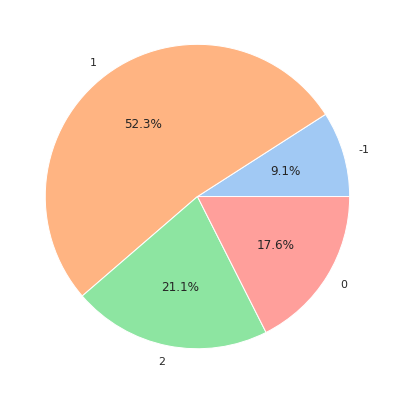

In [70]:
colors = sns.color_palette('pastel')[0:4]
plt.figure(figsize=(7,7))
value_counts = original_labeled_df['sentiment'].value_counts()
labels = original_labeled_df['sentiment'].unique()
value_counts = [value_counts[label] for label in labels]

plt.pie(value_counts, labels=labels, colors=colors, autopct='%1.1f%%')
plt.show()

### **Data Preprocessing**

In [11]:
extracted_df = twitter_extracted_data.drop_duplicates(subset=['tweet'], keep='first')
print("Length after removing duplicates: ", len(extracted_df))

Length after removing duplicates:  26905


In [12]:
# regexes for cleaning the tweets
mention_regex = r"@[A-Za-z0-9_]+"
hashtag_regex = r"#[A-Za-z0-9_]+"
url_regex = r'http\S+'

# creating a function for cleaning the tweet text
def clean_tweet_text(text):
    if not isinstance(text, str):
        return ""
    else:
        cleaned_text = text.lower()
        # removing @ mentions in the text
        cleaned_text = re.sub(mention_regex, "", cleaned_text)
        # removing hashtags from the text
        cleaned_text = re.sub(hashtag_regex, "", cleaned_text)
        # removing the URLs from the text
        cleaned_text = re.sub(url_regex, "", cleaned_text)
        # removing the RT indication from the text
        cleaned_text = re.sub(r'rt[\s]+', '', cleaned_text)
        # removing special characters from text
        cleaned_text = re.sub(r"[^A-Za-z0-9\s]+", " ", cleaned_text)
    
        return cleaned_text

In [13]:
# applying the cleaning function on the extracted dataframe
extracted_df.loc[:, 'cleaned_tweet'] = extracted_df['tweet'].apply(lambda x: clean_tweet_text(x))
extracted_df.loc[:, 'year'] = extracted_df['created_at'].apply(lambda x: x.split('-')[0])
extracted_df.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,author id,created_at,geo,id,lang,like_count,quote_count,reply_count,retweet_count,source,tweet,followers_count,username,name,location,cleaned_tweet,year
0,1.242448e+09,2013-12-30 23:59:40+00:00,,4.17807E+17,en,0.0,0.0,0.0,0.0,Twitter for Websites,MSM Glosses Over Irony of Global Warming Scien...,NaN,IdontbelieveinC,🐸AllWeAreSayingIsGiveTrumpAChance🐸,Somewhere nearby,msm glosses over irony of global warming scien...,2013
1,1.618546e+09,2013-12-30 23:59:38+00:00,,4.17807E+17,en,1.0,0.0,1.0,0.0,Twitter for Android,@mrgeology @Kentucky_SAM LOL!!! GLOBAL WARMING...,NaN,quebryant,queb *Notable Exception*,NaN,lol global warming is real oh wait lol,2013
2,6.234147e+07,2013-12-30 23:59:37+00:00,,4.17807E+17,en,0.0,0.0,0.0,1.0,Twitter for Android,RT @tony30088: Oh the irony: Global warming sc...,NaN,DenyJo,DenyJo,United States of America,oh the irony global warming scientists trap...,2013
3,2.741351e+07,2013-12-30 23:59:34+00:00,,4.17807E+17,en,0.0,0.0,3.0,0.0,TweetDeck,@DomSequitur Yeah he's in the Oz so he's actua...,NaN,macaulaybalkan,ed,Stolen land,yeah he s in the oz so he s actually difficul...,2013
4,3.875532e+07,2013-12-30 23:59:22+00:00,,4.17807E+17,en,0.0,0.0,0.0,0.0,dlvr.it,Tony Abbott's business adviser says Australia ...,NaN,lov3ny,lover ny,NYC,tony abbott s business adviser says australia ...,2013


In [14]:
# cleaning the tweets from the labeled dataset
labeled_df = original_labeled_df.copy()
labeled_df.loc[:, 'cleaned_tweet'] = labeled_df['message'].apply(lambda x: clean_tweet_text(x))
labeled_df.head()

,sentiment,message,tweetid,cleaned_tweet
0,-1,@tiniebeany climate change is an interesting h...,7.929270e+17,climate change is an interesting hustle as it...
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,7.931240e+17,watch right here as travels the world to ...
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,7.931240e+17,fabulous leonardo s film on change is brill...
3,1,RT @Mick_Fanning: Just watched this amazing do...,7.931250e+17,just watched this amazing documentary by leo...
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",7.931250e+17,pranita biswasi a lutheran from odisha giv...


In [15]:
vectorizer = TfidfVectorizer(max_features=2500, min_df=7, max_df=0.8)
processed_features = vectorizer.fit_transform(labeled_df['cleaned_tweet']).toarray()

In [16]:
# dividing the labeled dataset into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(processed_features, labeled_df['sentiment'], test_size=0.25, random_state=1337)

### **Model Training and Evaluation**
Training and testing different models to find the one with the best accuracy. The following models will be compared:


*   Random Forest Classifier
*   k Nearest Neighbor (kNN) Classifier
*   Logistic Regression
*   Linear Support Vector Machine Classifier
*   Extra Trees Classifier



Training a **Random Forest Classifier** on the train dataset

In [17]:
# training a random forest classifier on the labeled dataset

random_forest_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
random_forest_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=0)

In [18]:
# getting the predictions from the trained Random Forest Classifier
predictions = random_forest_classifier.predict(X_test)

In [19]:
# computing the metrics for evaluating the performance of 
# Random Forest Classifier

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))

[[ 181  102  629   51]
 [  21  592 1221  117]
 [   9  169 5249  267]
 [   4   57  800 1517]]
              precision    recall  f1-score   support

          -1       0.84      0.19      0.31       963
           0       0.64      0.30      0.41      1951
           1       0.66      0.92      0.77      5694
           2       0.78      0.64      0.70      2378

    accuracy                           0.69     10986
   macro avg       0.73      0.51      0.55     10986
weighted avg       0.70      0.69      0.65     10986

0.6862370289459312


Training and evaluating a **kNN classifier** on the train dataset

In [20]:
knn_classifier = KNeighborsClassifier(n_neighbors=5, metric="minkowski", p=2)
knn_classifier.fit(X_train, y_train)
knn_predictions = knn_classifier.predict(X_test)

# computing the metrics for evaluating the performance of 
# kNN Classifier

print(confusion_matrix(y_test, knn_predictions))
print(classification_report(y_test, knn_predictions))
print(accuracy_score(y_test, knn_predictions))

[[ 185  517  249   12]
 [ 104 1244  561   42]
 [ 251 2476 2816  151]
 [  62  857  667  792]]
              precision    recall  f1-score   support

          -1       0.31      0.19      0.24       963
           0       0.24      0.64      0.35      1951
           1       0.66      0.49      0.56      5694
           2       0.79      0.33      0.47      2378

    accuracy                           0.46     10986
   macro avg       0.50      0.41      0.41     10986
weighted avg       0.58      0.46      0.48     10986

0.4584926269797925


Training and evaluating a **Logistic Regression** Classifier

In [21]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(C=1, class_weight="balanced", max_iter=1000)
log_reg.fit(X_train, y_train)
log_reg_predictions = log_reg.predict(X_test)

# computing the metrics for evaluating the performance of 
# Logistic Regression Classifier

print(confusion_matrix(y_test, log_reg_predictions))
print(classification_report(y_test, log_reg_predictions))
print(accuracy_score(y_test, log_reg_predictions))

[[ 616  189  108   50]
 [ 296 1095  334  226]
 [ 498  854 3589  753]
 [  71  146  248 1913]]
              precision    recall  f1-score   support

          -1       0.42      0.64      0.50       963
           0       0.48      0.56      0.52      1951
           1       0.84      0.63      0.72      5694
           2       0.65      0.80      0.72      2378

    accuracy                           0.66     10986
   macro avg       0.60      0.66      0.62     10986
weighted avg       0.70      0.66      0.66     10986

0.6565628982341162


Training and evaluating a **Linear Support Vector Machine** (SVM) Classifier

In [22]:
from sklearn.svm import LinearSVC

svm_classifier = LinearSVC(class_weight="balanced")
svm_classifier.fit(X_train, y_train)
svm_predictions = svm_classifier.predict(X_test)

# computing the metrics for evaluating the performance of 
# Linear Support Vector Machine Classifier

print(confusion_matrix(y_test, svm_predictions))
print(classification_report(y_test, svm_predictions))
print(accuracy_score(y_test, svm_predictions))

[[ 554  183  175   51]
 [ 229  982  527  213]
 [ 322  590 4175  607]
 [  59  136  381 1802]]
              precision    recall  f1-score   support

          -1       0.48      0.58      0.52       963
           0       0.52      0.50      0.51      1951
           1       0.79      0.73      0.76      5694
           2       0.67      0.76      0.71      2378

    accuracy                           0.68     10986
   macro avg       0.62      0.64      0.63     10986
weighted avg       0.69      0.68      0.69     10986

0.6838703804842526


Testing the performance of a pre-trained model (using the **VADER sentiment analysis tool**). <br/>
VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.

In [23]:
## testing the performance of a pretrained model on the labeled dataset
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sid_obj = SentimentIntensityAnalyzer()


labeled_df2 = original_labeled_df.copy()
# changing the news label to neutral because the pretrained model only has 3 
# labels: positive, negative and neutral.
labeled_df2['sentiment'] = labeled_df2['sentiment'].apply(lambda x: 0 if x==2 else x)
labeled_df2['cleaned_tweet'] = labeled_df2['message'].apply(lambda x: clean_tweet_text(x))

X_train1, X_test1, y_train1, y_test1 = train_test_split(labeled_df2['cleaned_tweet'], labeled_df2['sentiment'], test_size=0.2, random_state=1337)

def get_sentiment_using_vader(sentence):
    sentiment_dict = sid_obj.polarity_scores(sentence)

    if sentiment_dict['compound'] >= 0.05 :
        sentiment = 1

    elif sentiment_dict['compound'] <= - 0.05 :
        sentiment = -1

    else :
        sentiment = 0

    return sentiment

predictions = [get_sentiment_using_vader(sent) for sent in X_test1]
print(confusion_matrix(y_test1, predictions))
print(classification_report(y_test1, predictions))
print(accuracy_score(y_test1, predictions))

[[ 380   97  285]
 [1140 1048 1281]
 [1900  985 1673]]
              precision    recall  f1-score   support

          -1       0.11      0.50      0.18       762
           0       0.49      0.30      0.37      3469
           1       0.52      0.37      0.43      4558

    accuracy                           0.35      8789
   macro avg       0.37      0.39      0.33      8789
weighted avg       0.47      0.35      0.39      8789

0.3528273978837183


Training and evaluating an **Extra Trees Classifier**

In [24]:
from sklearn.ensemble import ExtraTreesClassifier

extra_trees_classifier = ExtraTreesClassifier(n_estimators=100, random_state=0)
extra_trees_classifier.fit(X_train, y_train)
extra_trees_predictions = extra_trees_classifier.predict(X_test)

# computing the metrics for evaluating the performance of 
# Linear Support Vector Machine Classifier

print(confusion_matrix(y_test, extra_trees_predictions))
print(classification_report(y_test, extra_trees_predictions))
print(accuracy_score(y_test, extra_trees_predictions))

[[ 241  101  578   43]
 [  32  614 1199  106]
 [  21  135 5294  244]
 [   9   53  751 1565]]
              precision    recall  f1-score   support

          -1       0.80      0.25      0.38       963
           0       0.68      0.31      0.43      1951
           1       0.68      0.93      0.78      5694
           2       0.80      0.66      0.72      2378

    accuracy                           0.70     10986
   macro avg       0.74      0.54      0.58     10986
weighted avg       0.71      0.70      0.67     10986

0.7021663935918442


### **Findings:** </br>


*   The **Extra Trees Classifier** was found to give the best performance with 70.21% accuracy.
*   The Extra Trees Classifier also outperformed the pre-trained model (VADER) tool. This could also be because the labels for this particular use case are a little different from the normal sentiment analysis use case.
  *   Normally, sentiment analysis tasks have the labels: positive, negative and neutral.
  *   In this case, the labels are assigned based on whether the tweet supports man-made climate change. 


### **Prediction**<br/>
Using the Extra Trees Classifier to get predictions for the extracted tweet data.

In [25]:
extracted_process_features = vectorizer.fit_transform(extracted_df['cleaned_tweet']).toarray()

In [26]:
extracted_df_predictions = extra_trees_classifier.predict(extracted_process_features)
extracted_df['prediction'] = extracted_df_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [27]:
extracted_df['prediction'].value_counts()

 1    18701
 0     5895
 2     2058
-1      251
Name: prediction, dtype: int64

### **Data Visualization**

In [28]:
label_name_mapping = {
    -1: "Anti",
     0: "Neutral",
     1: "Pro",
     2: "News",
}
extracted_df["predicted_name"] = extracted_df["prediction"].apply(lambda num: label_name_mapping[num])
extracted_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,author id,created_at,geo,id,lang,like_count,quote_count,reply_count,retweet_count,source,tweet,followers_count,username,name,location,cleaned_tweet,year,prediction,predicted_name
0,1.242448e+09,2013-12-30 23:59:40+00:00,,4.17807E+17,en,0.0,0.0,0.0,0.0,Twitter for Websites,MSM Glosses Over Irony of Global Warming Scien...,NaN,IdontbelieveinC,🐸AllWeAreSayingIsGiveTrumpAChance🐸,Somewhere nearby,msm glosses over irony of global warming scien...,2013,0,Neutral
1,1.618546e+09,2013-12-30 23:59:38+00:00,,4.17807E+17,en,1.0,0.0,1.0,0.0,Twitter for Android,@mrgeology @Kentucky_SAM LOL!!! GLOBAL WARMING...,NaN,quebryant,queb *Notable Exception*,NaN,lol global warming is real oh wait lol,2013,0,Neutral
2,6.234147e+07,2013-12-30 23:59:37+00:00,,4.17807E+17,en,0.0,0.0,0.0,1.0,Twitter for Android,RT @tony30088: Oh the irony: Global warming sc...,NaN,DenyJo,DenyJo,United States of America,oh the irony global warming scientists trap...,2013,1,Pro
3,2.741351e+07,2013-12-30 23:59:34+00:00,,4.17807E+17,en,0.0,0.0,3.0,0.0,TweetDeck,@DomSequitur Yeah he's in the Oz so he's actua...,NaN,macaulaybalkan,ed,Stolen land,yeah he s in the oz so he s actually difficul...,2013,1,Pro
4,3.875532e+07,2013-12-30 23:59:22+00:00,,4.17807E+17,en,0.0,0.0,0.0,0.0,dlvr.it,Tony Abbott's business adviser says Australia ...,NaN,lov3ny,lover ny,NYC,tony abbott s business adviser says australia ...,2013,0,Neutral


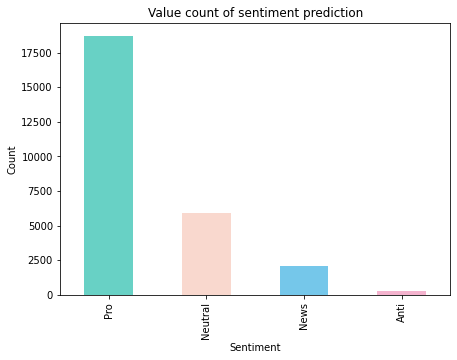

In [29]:
# plotting a bar graph to show count of tweet sentiment in the extracted tweets
fig = plt.figure(figsize=(7,5))
color = ['#68D1C5', '#F9D8CE','#75C7EA', '#F4B3CE']
extracted_df['predicted_name'].value_counts().plot(kind='bar',color = color)
plt.title('Value count of sentiment prediction')
plt.ylabel('Count')
plt.xlabel('Sentiment')
plt.grid(False)
plt.show()

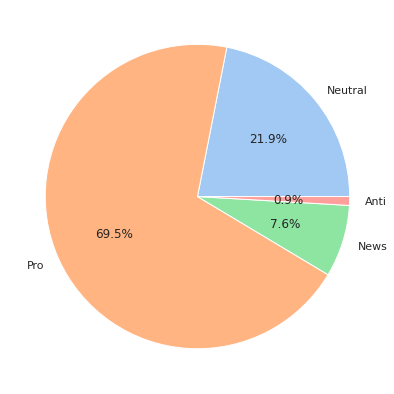

In [68]:
# creating a pie chart to see the distribution of sentiment polarities in the 
# predictions
colors = sns.color_palette('pastel')[0:4]
plt.figure(figsize=(7,7))
value_counts = extracted_df['predicted_name'].value_counts()
labels = extracted_df['predicted_name'].unique()
value_counts = [value_counts[label] for label in labels]

plt.pie(value_counts, labels=labels, colors=colors, autopct='%1.1f%%')
plt.show()

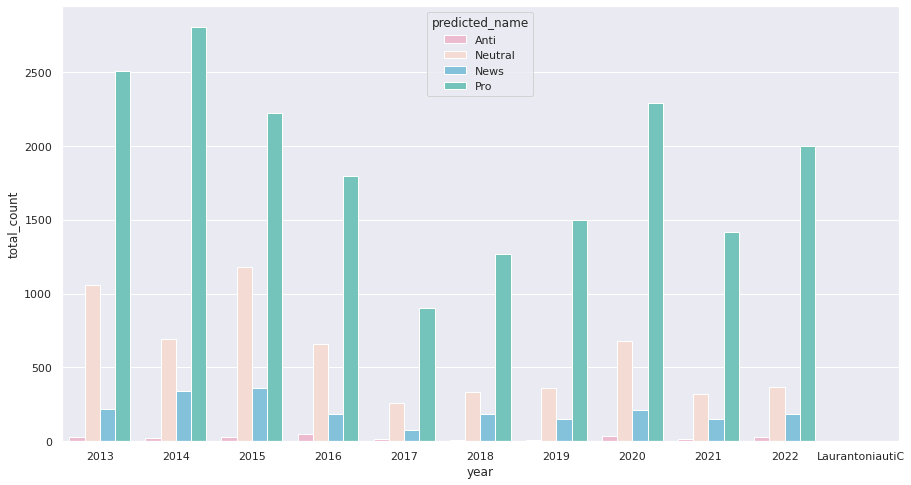

In [31]:
# plotting a bar graph to see the sentiment polarity across the years
barplot_df = extracted_df.groupby(['year', 'predicted_name']).agg(total_count=
                                                        ("predicted_name", 'count'))
barplot_df = barplot_df.reset_index()
sns.set(rc = {'figure.figsize':(15,8)})
sns.barplot(x="year", y="total_count", hue="predicted_name", data=barplot_df, palette=['#F4B3CE', '#F9D8CE', '#75C7EA', '#68D1C5'])
plt.show()

### Geolocation of tweets<br/>
Plotting the location of the tweets predicted as -1 (Anti) on the world map to see where the non-belief in man-made climate change is more prevalent.

In [45]:
!pip install geopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
# Import the required library
from geopy.geocoders import Nominatim

# Initialize Nominatim API
geolocator = Nominatim(user_agent="MyApp")

def get_latitude_longitude(location):
    _location = geolocator.geocode(location, timeout=10)
    if _location:
        return (_location.latitude, _location.longitude)
    else:
        return (None, None)

In [47]:
negative_df = extracted_df[extracted_df['prediction']==-1]
negative_df[['latitude', 'longitude']] = negative_df.apply(lambda x: get_latitude_longitude(x['location']), axis=1, result_type='expand')
negative_df.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,author id,created_at,geo,id,lang,like_count,quote_count,reply_count,retweet_count,source,...,followers_count,username,name,location,cleaned_tweet,year,prediction,predicted_name,latitude,longitude
384,326639353.0,2013-12-30 23:25:40+00:00,,4.17799E+17,en,0.0,0.0,0.0,5.0,Twitter for iPhone,...,NaN,szabosolicitors,George Szabo,"Sydney, NSW, Australia",global warming science boat may trapped non ex...,2013,-1,Anti,-33.869844,151.208285
392,407578091.0,2013-12-30 23:25:21+00:00,,4.17799E+17,en,0.0,0.0,1.0,0.0,Hootsuite,...,NaN,St_Gillard,St. Gillard,beachside house. GW is a SCAM,global warming science boat may trapped non ex...,2013,-1,Anti,NaN,NaN
831,165725223.0,2013-12-30 22:49:16+00:00,,4.1779E+17,en,0.0,0.0,0.0,0.0,Twitter for iPhone,...,NaN,shoutinthewind,average joe,NaN,deny global warming natural event happened man...,2013,-1,Anti,46.314475,11.048029
1092,305958213.0,2013-12-30 22:25:11+00:00,,4.17783E+17,en,0.0,0.0,0.0,0.0,Twitter for Android,...,NaN,9INS1DE1JOB,Truth Seeker,All Roads Lead To Rome,proof hoax,2013,-1,Anti,NaN,NaN
1093,407578091.0,2013-12-30 22:25:08+00:00,,4.17783E+17,en,1.0,0.0,0.0,5.0,Hootsuite,...,NaN,St_Gillard,St. Gillard,beachside house. GW is a SCAM,global warming science boat may trapped non ex...,2013,-1,Anti,NaN,NaN


In [48]:
negative_df.to_csv("updated_with_location.csv", index=False)

In [49]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


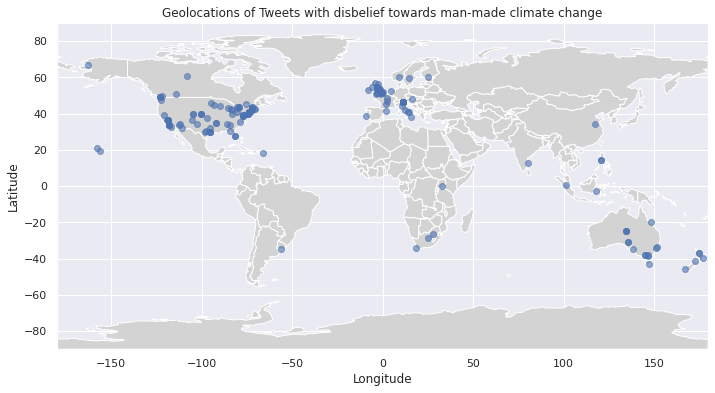

In [50]:
import geopandas as gpd

# From GeoPandas, our world map data
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(12, 6))
worldmap.plot(color="lightgrey", ax=ax)

threshold=20
# Plotting our Impact Energy data with a color map
x = negative_df['longitude']
y = negative_df['latitude']
plt.scatter(x, y, alpha=0.6, vmin=0, vmax=threshold,
            cmap='autumn')

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])

plt.title("Geolocations of Tweets with disbelief towards man-made climate change")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

### **Text analysis** <br/>

Looking into extracted tweet data to get further understanding of the nature of the tweets.

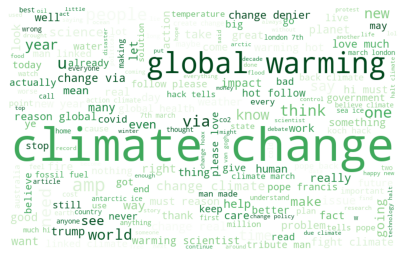

In [55]:
from textblob import TextBlob
from wordcloud import WordCloud

#create a function for wordcloud
def create_wordcloud(text, colormap):    
    all_words = ' '.join([tweets for tweets in text])
    word_cloud = WordCloud(background_color='white', width=800, height=500, random_state=21, max_font_size=130, colormap=colormap).generate(all_words)
    plt.figure(figsize=(7,7))
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.show()

# word cloud for positive tweets
positive_tweets = extracted_df.loc[extracted_df['prediction']==1, 'cleaned_tweet']
create_wordcloud(positive_tweets, colormap="Greens")


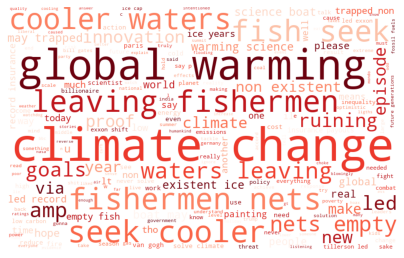

In [56]:
# word cloud for negative tweets
negative_tweets = extracted_df.loc[extracted_df['prediction']==-1, 'cleaned_tweet']
create_wordcloud(negative_tweets, colormap="Reds")

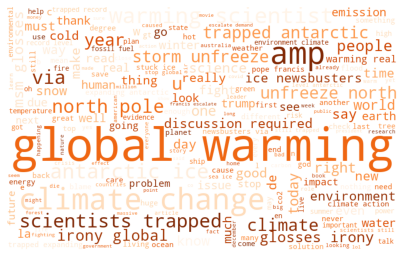

In [57]:
# word cloud for neutral tweets
neutral_tweets = extracted_df.loc[extracted_df['prediction']==0, 'cleaned_tweet']
create_wordcloud(neutral_tweets, colormap="Oranges")

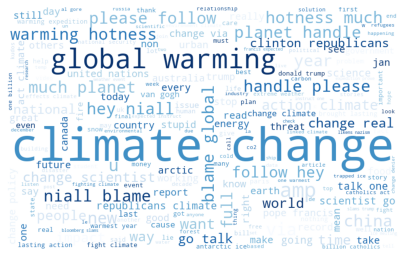

In [58]:
# word cloud for news tweets
news_tweets = extracted_df.loc[extracted_df['prediction']==2, 'cleaned_tweet']
create_wordcloud(news_tweets, colormap="Blues")

Getting the top 20 words used in the extracted tweet data

In [36]:
#break each tweet sentence into words
sentences = []
for word in extracted_df['cleaned_tweet']:
    sentences.append(word)

lines = list()
for line in sentences:
    words = line.split()
    for w in words:
        lines.append(w)

In [65]:
nlp = spacy.load("en_core_web_sm")

#stemming all the words to their root word
stemmer = SnowballStemmer(language='english')
stem=[]
for word in lines:
    if word not in nlp.Defaults.stop_words:
        stem.append(stemmer.stem(word))

#creates a new dataframe for the stem and shows the count of the most used words
df = pd.DataFrame(stem)
df = df[0].value_counts()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


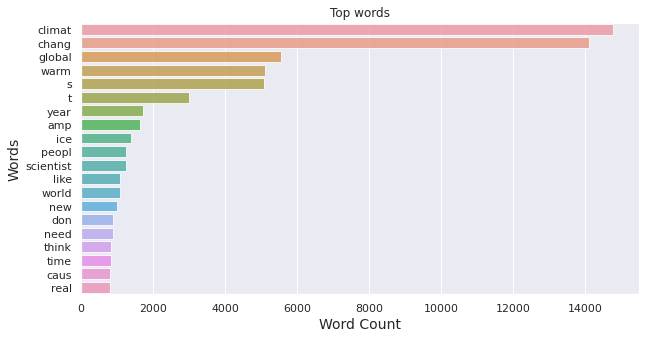

In [66]:
# plotting a barplot with the top 20 used words
df = df[:20]
plt.figure(figsize=(10,5))
sns.barplot(df.values, df.index, alpha=0.8)
plt.title('Top words')
plt.xlabel('Word Count', fontsize=14)
plt.ylabel('Words', fontsize=14)
plt.show()

### Getting the top hashtags used in each sentiment

Finding the top 15 hashtags used for each sentiment label in the extracted dataset


In [42]:
import itertools
from tqdm.auto import tqdm

top_15_hashtags = {}
group_by_prediction = extracted_df.groupby("predicted_name")
for sentiment, group in tqdm(group_by_prediction):
    hashtags = group["tweet"].apply(lambda x: re.findall(r"#(\w+)", str(x)))
    hashtags = itertools.chain(*hashtags)
    frequency = nltk.FreqDist(hashtags)

    hashtags_df = pd.DataFrame({"hashtags": list(frequency.keys()),
                                "counts": list(frequency.values())})
    top_15 = hashtags_df.nlargest(15, columns=["counts"])
    top_15_hashtags[sentiment] = top_15.reset_index(drop=True)
display(pd.concat(top_15_hashtags, axis=1).head(n=10))

  0%|          | 0/4 [00:00<?, ?it/s]

Anti               Neutral                  News         \
        hashtags counts       hashtags counts       hashtags counts   
0  climatechange     32  climatechange   1040  climatechange    132   
1  ClimateChange     10  ClimateChange    582  ClimateChange     69   
2         auspol      9  globalwarming    177        climate     53   
3  globalwarming      8        climate    161  globalwarming     21   
4        climate      6  GlobalWarming    130        Climate     20   
5    environment      4         auspol     83         auspol     19   
6     StormFrank      3     AvoidFlood     82  ClimateAction     13   
7         energy      3      SaveWater     82  ClimateCrisis     12   
8  ClimateAction      3  ClimateAction     57  Climatechange     10   
9     technology      3    environment     54  GlobalWarming     10   

             Pro         
        hashtags counts  
0  climatechange   1384  
1  ClimateChange    939  
2        climate    400  
3  globalwarming    269  
4  GlobalWarming    169  
5        Climate    142  
6  TimeToAct2015    128  
7  ClimateAction    105  
8   HappyNewYear     95  
9  climateaction     91

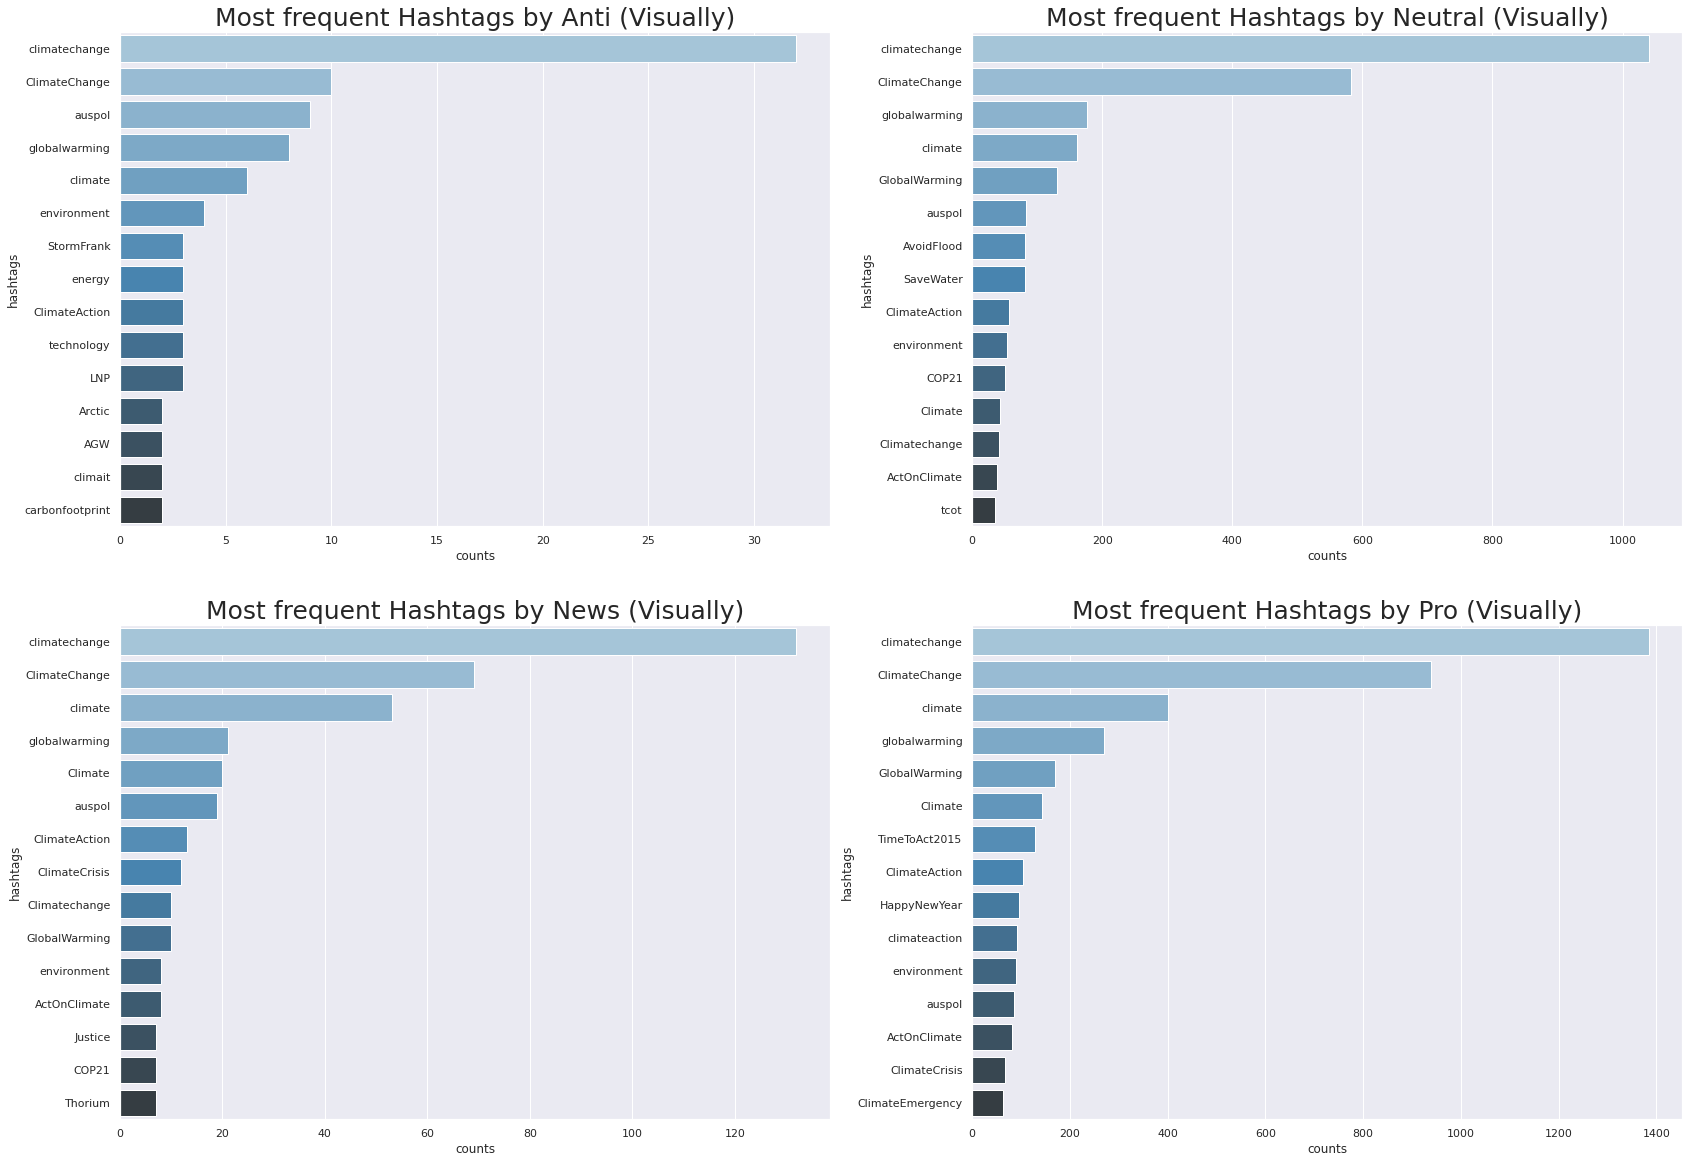

In [72]:
fig, axes = plt.subplots(2, 2, figsize=(28, 20))
counter = 0

for sentiment, top in top_15_hashtags.items():
    sns.barplot(data=top, y="hashtags", x="counts", palette="Blues_d", ax=axes[counter // 2, counter % 2])
    axes[counter // 2, counter % 2].set_title(f"Most frequent Hashtags by {sentiment} (Visually)", fontsize=25)
    counter += 1
plt.show()

### Topic Detection for Network Analysis using **Latent Dirichlet Allocation (LDA)**

In [39]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

stop_words = stopwords.words('english')

def get_words(tweet_list):
    for tweet in tweet_list:
        yield(simple_preprocess(str(tweet), deacc=True))

def remove_stopwords(text):
    cleaned_text = " ".join([word for word in text.split() if word not in stop_words])   
    return cleaned_text

# preparing the corpus
extracted_df['cleaned_tweet'] = extracted_df['cleaned_tweet'].apply(lambda x: remove_stopwords(x))
complete_data_list = extracted_df['cleaned_tweet'].to_list()
words = list(get_words(complete_data_list))
id2word = corpora.Dictionary(words)
corpus = [id2word.doc2bow(word) for word in words]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [40]:
# setting the number of distinct topics to 15
topic_count = 15

# creating the LDA model for topic detection
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=topic_count)
doc_lda = lda_model[corpus]

In [41]:
# analyzing the results from topic detection
import pyLDAvis.gensim_models as gensimvis
import pickle
import pyLDAvis

pyLDAvis.enable_notebook()

LDAvis_data_filepath = '/content/lda_topics'


LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, '/content/lda_topics.html')

LDAvis_prepared

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
1      0.081672 -0.081825       1        1  9.391052
2     -0.234006 -0.101089       2        1  8.296940
14     0.139334  0.002834       3        1  8.128480
6      0.090664 -0.046477       4        1  8.123171
10     0.011081 -0.073625       5        1  7.964635
8      0.106108 -0.007485       6        1  6.882351
11    -0.086334 -0.025284       7        1  6.470056
12    -0.145320  0.025207       8        1  6.187014
7      0.116307  0.040903       9        1  6.150330
13     0.033598 -0.061943      10        1  6.143418
5      0.056435  0.013889      11        1  5.922496
3      0.000497  0.053922      12        1  5.781274
9     -0.013654 -0.000819      13        1  5.499290
4     -0.100821 -0.021738      14        1  5.013281
0     -0.055561  0.283531      15        1  4.046212, topic_info=         Term          Freq         Total Category  logprob  loglift
10    warming   2522.000000   2522.000000  Default  30.0000  30.0000
3      global   2803.000000   2803.000000  Default  29.0000  29.0000
60    climate  13539.000000  13539.000000  Default  28.0000  28.0000
59     change  12566.000000  12566.000000  Default  27.0000  27.0000
2505      van    413.000000    413.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
121    pretty     44.960953     99.779695  Topic15  -5.4919   2.4102
206       amp     76.851942   1375.997207  Topic15  -4.9558   0.3223
4941    trump     58.023808    361.012112  Topic15  -5.2368   1.3793
3      global     55.530637   2803.785596  Topic15  -5.2807  -0.7144
10    warming     42.615382   2522.283571  Topic15  -5.5455  -0.8733

[1094 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
4151      6  0.716892        able
4151     12  0.276981        able
2280      1  0.954167    absolute
1344      1  0.011559  absolutely
1344      3  0.982482  absolutely
...     ...       ...         ...
926       1  0.877281        york
926       6  0.092345        york
1421      6  0.934957       young
1421      8  0.019277       young
1421     13  0.038555       young

[3322 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 15, 7, 11, 9, 12, 13, 8, 14, 6, 4, 10, 5, 1])

In [87]:
# creating a network graph to understand the retweet network of the tweets
import networkx as nx

retweet_graph = nx.DiGraph()

403


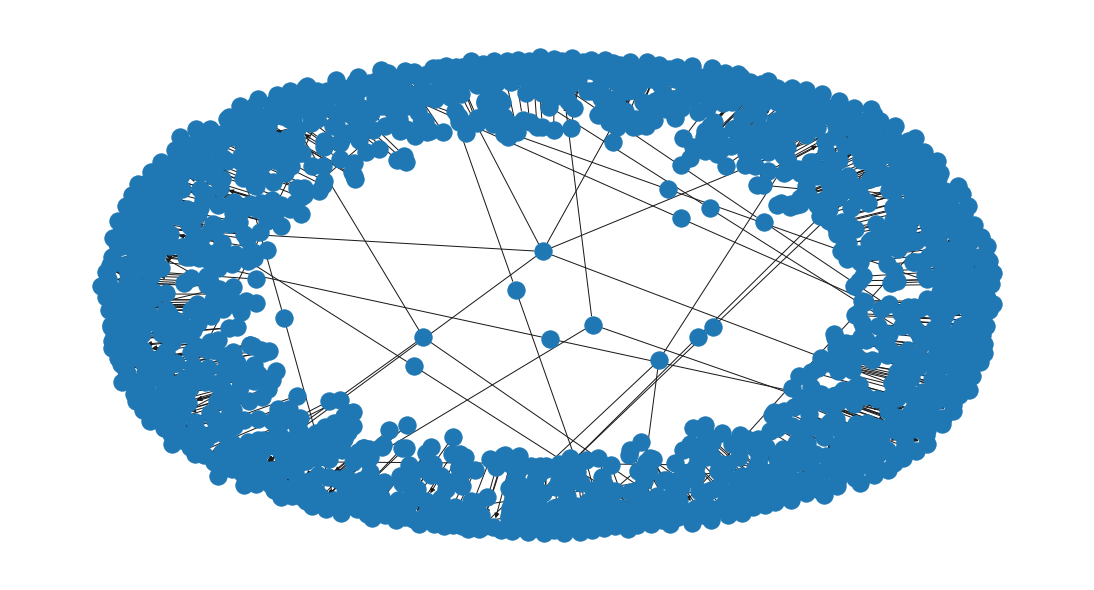

In [89]:
from pyvis.network import Network
from IPython.core.display import display, HTML

df_with_users = twitter_extracted_data[~twitter_extracted_data['username'].isnull()]
df_with_users = df_with_users.drop_duplicates(subset=["tweet"])
df_with_users = df_with_users[df_with_users['retweet_count']>500]
print(df_with_users.shape[0])
for i, row in df_with_users.iterrows():
    author = "@{0}".format(row['username'])
    tweet = row['tweet']
    created_at = row['created_at']

    retweets = set(re.findall(r"RT @(\w+)", tweet))
    if len(retweets) > 0:
        for _retweet in retweets:
            user = "@{0}".format(_retweet)
            retweet_graph.add_edge(author, user, Timestamp=created_at)

nx.draw(retweet_graph)